# Optimal Parking
---

In crowded urban areas, attempting to find street parking near your destination can be a stressful and aggravating task. You might attempt to pull into a spot only to find you lack the space (or skill) to fit in the narrow gap. Even worse, you might find that inconsiderate drivers have managed to take up 5 potential spots with only three vehicles. Considering varying vehicle size, perfect use of curb space in a busy environment is unlikley. What we attempt to find in this paper is an optimal parking strategy, that if followed, would lead to the most vehicles finding a spot near their destination.

To takle the problem, we simulate example situations of increasing complexity. Each situation consists of **drivers** and a **neighborhood**. 

Each **driver** is has a specified car, skill, parking duration, distance tolerance, and parking policy. 
- For simplicity, the size of each car is drawn from a gaussian distrubution with mean of 4.25m and standard-deviation of .5m. During sampling, cars with a length of less than 3 or greater than 5.5 meters are rounded up or down to these respective bounds.
- Skill dictates what percentage greater than the length of the car is required for the driver to actually park the car if parallel parking is necessary. Though parallel parking is technically feasable in any space longer than the car itself [[1]](http://www.damtp.cam.ac.uk/user/md327/ISlecture_notes_2012.pdf), drivers will not attempt to park in any space with less than 1 meter of free-room, regardless of skill. Skill also determines how close to other cars the driver will park in the case that the space does not require parallel parking (i.e they can pull in or back in directly).
- Parking duration is the amount of time (measured in park attempts) that the driver will remain parked. For example, a driver with `park_time = 5` will vacate their parking spot after 5 other drivers attempt to park (regardless of each attempt's success).
- Distance tolerance is only implemented in some scenarios where paid parking is present. Under the assumption that paid parking is always available, distance tolerance determines how much further a driver will look beyond the closest paid parking (not yet implemented).
- The driver policy is intended to capture the variability in driver mindset. For example, a driver in a rush will likley park less carefully than one with plenty of time. Some drivers may be more concious of leaving space for others, while some might not care and take up much more space than necessary. By manipulating the distribution of driver policies, we can observe how effectivley parking space is used in both ideal and real-world situations.

Each **neighborhood** is defined as an undirected graph of streets (edges) and intersections (verticies). They may be as simple as a single curb or as complex as a neighborhood with both free and paid parking.
- Drivers can only park along one side of the street (though this may be changed in the future)
- Interruptions to a street such as fire lanes or driveways are included by adding a vertex with only two edges.
- For now, drivers only care that they can park _somewhere_ in the neighborhood and have no preference for particular streets. This may be changed.

In [1]:
using Plots, DataFrames, LinearAlgebra

## Drivers

In [10]:
mutable struct driver
    car_length::Float32
    driver_skill::Float32
    parktime::Int
    policy::Int
    driverNo::Int
end

num_drivers = 100

# Car length distribution
mean_len = 4.25
len_dev = 0.5

function create_driver(driverNo)
    car_length = round(mean_len .+ len_dev * randn(), digits=1)
    driver_skill = abs(rand(0:0.05:1))
    parktime = rand(60:100)
    policy = 0
    return driver(car_length, driver_skill, parktime, policy, driverNo)
end

function create_n_drivers(n)
    drivers = [create_driver(i) for i in 1:n]
    return drivers
end

function required_space(driver::driver)
    return driver.car_length + 1 + (driver.car_length * 0.2(1-driver.driver_skill))
end

required_space (generic function with 1 method)

#### Policies

## The Neighborhood

In [12]:
"""
Input dimensions as pair tuples (nodes_across, length), (nodes_down, length).

"""
function build_hood(layout::Tuple{Int, Int},
                    length::Tuple{Int, Int},)

    rows = layout[1]; cols = layout[2]
    row_length = length[1]; col_length = length[2]
    n = rows * cols
    M = zeros(Int, (n, n))
    for r in 1:rows
        for c in 1:cols
            i = (r - 1) * cols + c
            # Two inner diagonals
            if c > 1
                M[i - 1, i] = row_length
                M[i, i - 1] = row_length
            end
            # Two outer diagonals
            if r > 1
                M[i - cols, i] = col_length
                M[i, i - cols] = col_length
            end
        end
    end
    return M
end

build_hood

In [13]:
# heatmap(build_hood((3,5), (50,20)))
hood = build_hood((2,2), (50,20))

4×4 Matrix{Int64}:
  0  50  20   0
 50   0   0  20
 20   0   0  50
  0  20  50   0

## Simulation

#### Construct Neighborhood
1. TODO

#### Car parking
1. select curb
2. find length of available open spaces on curb (spot_length)
3. if space exists that will fit car_length * driver_skill, the car will take the spot for the driver's parking duration and then vacate
4. when excess space is available (i.e. car_length * driver_skill < spot_length), allocate the extra space according to the parking policy.
    - Drivers will not perfectly fulfill the policy, rather, they will fail by driver_skill%, provided this will not cause them to hit another vehicle
5. if no space is available, the a counter ticks up and the process repeats

In [14]:
function park_sim(drivers::Vector{driver}, curb_length::Real)

    tick = 0
    no_spot = 0
    available_spaces = [(0.0, Float64(curb_length), 0)] #rear, front, driver to right (0 if none)
    parked_cars = []

    while true
        tick += 1

        # end simulation once all of drivers have searched for a spot
        if isempty(drivers)
            break 
        end

        driver = pop!(drivers) # extract last driver from list
        req_space = required_space(driver)
        free_space = (req_space - driver.car_length)/2 #assume driver leaves same space in front/rear (change with policy)
        spot_index = 0 #track where on curb the current driver is parking
        found_spot = false
        
        # Note: this causes drivers to look for spots from start to end of curb
        for (i, (rear, front, dNo)) in enumerate(available_spaces)
            spot = front - rear # calculate length of available spot
            if spot >= req_space
                found_spot = true # driver found spot that will fit car with sufficient room
                spot_index = i
                break
            end
        end

        if found_spot
            # update available_spaces after car has parked
            rear, front, dNo_right = available_spaces[spot_index]
            # add policy dependent start_end function here
            car_start = rear+free_space
            car_end = car_start+driver.car_length

            splice!(available_spaces, spot_index, [(rear, car_start, driver.driverNo), (car_end, front, dNo_right)])
            # add driver to list of parked cars
            push!(parked_cars, (car_start, car_end, driver.parktime, driver.driverNo))
        else
            no_spot += 1 # update number of divers unable to park
        end

        # update parktime for each of the parked vehicles
        if !isempty(parked_cars)
            parked_cars = map(x -> (x[1], x[2], x[3] - 1, x[4]), parked_cars)
        end

        # reduce time left in spot, if zero, remove driver from parked cars list and reallocate their spot to available_spaces
        for (i, (car_start, car_end, parktime, driverNo)) in enumerate(parked_cars)
            if parktime <= 0
                deleteat!(parked_cars, i)
                parking_space = findfirst(x -> x[3] == driverNo, available_spaces)
                now_available = (available_spaces[parking_space][1], available_spaces[parking_space+1][2], available_spaces[parking_space+1][3])
                splice!(available_spaces, parking_space:parking_space+1, [now_available])
            end
        end
    end

    residual_space = curb_length - sum(map(x -> (x[2] - x[1]), parked_cars))
    println("There were ", round(residual_space, digits = 3), " meters of unused curb space. (",
             round(100(residual_space/curb_length), digits = 3), "%)")
    println(no_spot, " drivers were unable to find a spot.")

    park_results = Dict("parked_cars" => parked_cars,
                        "residual_space" => residual_space,
                        "no_spot" => no_spot)

    return(park_results)
end

park_sim (generic function with 1 method)

In [15]:
curb_length = 100.0 # length of the long side of a "Chicago block" in meters
drivers = create_n_drivers(500)

result = park_sim(drivers, curb_length);

There were 25.5 meters of unused curb space. (25.5%)
375 drivers were unable to find a spot.


In [16]:
# # Interactive plot with PlotlyJS backend
# function plot_cars(curb_length, park_simulation)
#     car_positions = park_simulation["parked_cars"]
    
#     starts = map(x -> x[1], car_positions)
#     ends = map(x -> x[2], car_positions)
#     driverNo = map(x -> x[4], car_positions)

#     x = [starts; ends]
#     y = ones(2*size(x)[1])
#     traces = [scatter(x=[0, curb_length], y=[0.1, 0.1], mode="lines", line=attr(width=100, color="black"))]
    
#     for i in eachindex(starts)
#         trace = scatter(x=[starts[i],ends[i]], y=[0.2,0.2], text="Driver $(driverNo[i])", mode="lines", line=attr(width=30))
#         push!(traces, trace)
#     end


#     layout = Layout(showlegend=false, xaxis=attr(ticks="outside", tick0=0, dtick=10),
#                     yaxis=attr(showticklabels=false, range=[0, 0.3]))
    
    
#     plot(traces, layout)
# end

# plot_cars(curb_length, result)


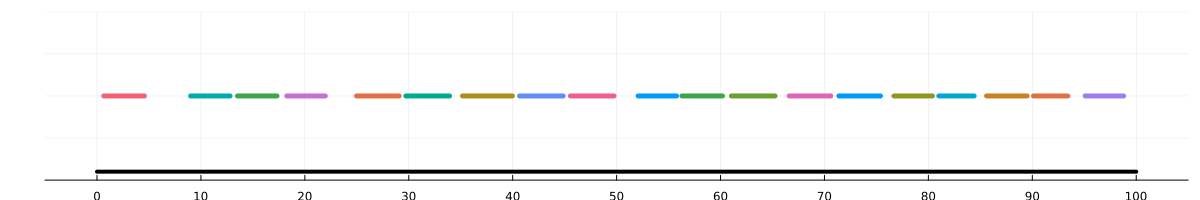

In [17]:
# Static plot, will require kernel restart and switch to Plots (GS) backend
function plot_cars(curb_length, park_simulation)

    car_positions = park_simulation["parked_cars"]
    plot(size=(1200, 200), legend=false)

    starts = map(x -> x[1], car_positions)
    ends = map(x -> x[2], car_positions)

    for i in eachindex(starts) # plot each car on the curb
        plot!([starts[i], ends[i]], [1,1], linewidth=5, label="")
    end

    xticks!(0:10:curb_length)
    yaxis!(:off)
    plot!([0, curb_length], [0.1, 0.1], linewidth=4, color=:black)  # Plot the "curb" as black line
    xlims!(-5, curb_length+5)  # Set the x-axis limits slightly wider than the number line range
    ylims!(0, 2)  # Set the y-axis limits to center the number line
end

plot_cars(curb_length, result)

In [3]:
a =[0 2 1 0
    2 0 0 1
    1 0 0 2
    0 1 2 0]

4×4 Matrix{Int64}:
 0  2  1  0
 2  0  0  1
 1  0  0  2
 0  1  2  0

In [ ]:
b =[0 2 0 1 0 0
    2 0 2 0 1 0
    0 2 0 0 0 1
    1 0 0 0 2 0
    0 1 0 2 0 2
    0 0 1 0 2 0]

In [ ]:
c =[0 2 0 0 1 0 0 0 0 0 0
    2 0 2 0 0 1 0 0 0 0 0
    0 2 0 2 0 0 1 0 0 0 0
    1 0 0 0 ]

# TODO

1. Add option to `park` so that drivers prefer bigger spaces (right now they always take the first spot that fits their car and skill level)
2. Create driver policies to determine how they will chose a spot
3. Compartmentalize functions as much as possible
4. Create gif animation of parking lot over time